# Neural Network on UCI Activity

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

## Read Data

In [ ]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
display(df_train.head(5))

## Visualize data

In [ ]:
display(df_train.head(5))
display(df_train.describe())
# df_train.hist(bins=20, figsize=(30,30))
# plt.show()

# display(df_test.head(5))
# display(df_test.describe())

label_ls = list(set(df_train['Activity'].tolist()))
print(label_ls)

## Pytorch data loader

In [253]:
label_ls = ['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING', 'STANDING', 'SITTING', 'LAYING']

class DatasetFromPandas(Dataset):
    def __init__(self, df):
        
        ## Label processing, standing or not
        df['label'] = df.apply(lambda row : label_ls.index(row[562]), axis = 1)
        
        x = df.iloc[:,0:500].values
        y = df['label'].values
        
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int64)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

In [411]:
my_train = DatasetFromPandas(df_train)
my_test = DatasetFromPandas(df_test)
batch_size = 20

print(my_train.y)
print(my_test.y)

# Create data loaders.
train_dataloader = DataLoader(my_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(my_test, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape) # N: batch size, C: channel, H: height, W: width
    print("Shape of y: ", y.shape, y.dtype)
    break
    
# Creating Models
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

tensor([3, 3, 3,  ..., 0, 0, 0])
tensor([3, 3, 3,  ..., 0, 0, 0])
Shape of X [N, C, H, W]:  torch.Size([20, 500])
Shape of y:  torch.Size([20]) torch.int64
Using cpu device


## Model Design

In [412]:
# Define model
# Simple nn with only linear and relu layer
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()    ## Flattens a contiguous range of dims into a tensor. For use with Sequential.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 6),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=500, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=6, bias=True)
    (5): ReLU()
  )
)


In [413]:
# Optimizing the Model Parameters
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [414]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss_fn(pred, y).item()
        
        # Backpropagation (three standard steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f" train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss
    # print(f"Avg train loss: {train_loss:>8f} \n")
            
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    

## Model Training

In [ ]:
epochs = 400
train_loss_ls = []
test_loss_ls = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, correct = test(test_dataloader, model)
    train_loss_ls.append(train_loss)
    test_loss_ls.append(test_loss)
    print(f"Epoch {t+1}", "train_loss:", train_loss, "test_loss:", test_loss, "Accuracy:", (100*correct))
print("Done!")


## Plot

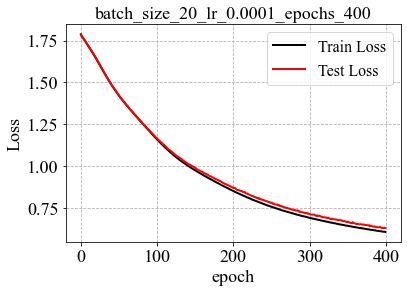

In [416]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize':16,
         'axes.labelsize':18,
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'font.family':'Times New Roman'}
pylab.rcParams.update(params)

ini_ind = 0
cut_ind = epochs
epoch_ls = [i for i in range(epochs)]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_train_loss, = ax.plot(epoch_ls[ini_ind:cut_ind], train_loss_ls[ini_ind:cut_ind], color="BLACK", lw=2)
ax_test_loss, = ax.plot(epoch_ls[ini_ind:cut_ind], test_loss_ls[ini_ind:cut_ind], color="RED", lw=2)

# ax.set_xlim([-1,110])
# ax.set_ylim([-0.03,1.03])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
ax.grid(ls='--')
title = 'batch_size_'+str(batch_size)+'_lr_'+str(lr)+'_epochs_'+str(epochs)
ax.set_title(title)

legend1 = plt.legend([ax_train_loss, ax_test_loss], ['Train Loss', 'Test Loss'])

# plt.setp(ax, xticks=[0,10, 20, 30, 40, 60,80, 100 ])
# plt.setp(ax, yticks=[0, 0.25, 0.5, 0.75,1.0])

figure_path = '/Users/yi/PycharmProjects/uci_activity/figures'
figure_name = 'loss_batch_size_'+str(batch_size)+'_lr_'+str(lr)+'_epochs_'+str(epochs)+'.pdf'
fig.savefig(os.path.join(figure_path,figure_name), bbox_inches='tight')

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize':16,
         'axes.labelsize':16,
         'axes.titlesize':16,
         'xtick.labelsize':16,
         'ytick.labelsize':16,
         'font.family':'Times New Roman'}
pylab.rcParams.update(params)

# Build confusion matrix
classes = ['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING', 'STANDING', 'SITTING', 'LAYING']

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)

df_cf = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
df_cm = df_cf.div(df_cf.sum(axis=1), axis=0)

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},)

plt.xticks(rotation = 30) # Rotates X-Axis Ticks by 45-degrees

figure_path = '/Users/yi/PycharmProjects/uci_activity/figures'
figure_name = 'confusion_matrix_'+str(batch_size)+'_lr_'+str(lr)+'_epochs_'+str(epochs)+'.png'
plt.savefig(os.path.join(figure_path,figure_name), bbox_inches='tight', dpi=300)

## Model Visualization

In [287]:
from torchviz import make_dot

for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    break

# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

make_dot(pred, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'